# Web Scraping for Indeed.com and Predicting Salaries - EDA & Modelling

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import re

In [264]:
df_salary = pd.read_csv('df_final_no_log')

### EDA

In [245]:
df_salary.groupby('country')['salary'].mean()

country
Canada           53755.557857
australia        68256.213596
uk               44575.109628
united states    77422.715068
Name: salary, dtype: float64

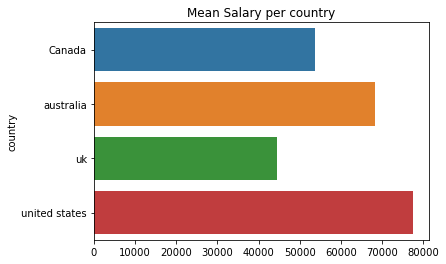

In [252]:
plt.title('Mean Salary per country')
sns.barplot(x=df_salary.groupby('country')['salary'].mean().values, 
            y=df_salary.groupby('country')['salary'].mean().index);

In [253]:
df_salary.groupby('remote')['salary'].mean()

remote
Hybrid    54846.398742
Office    57792.662782
Remote    73237.396794
Name: salary, dtype: float64

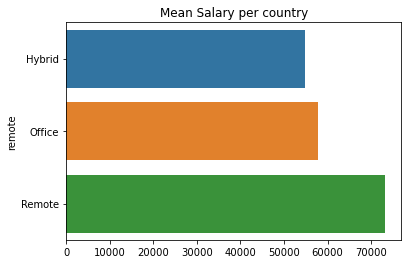

In [254]:
plt.title('Mean Salary per country')
sns.barplot(x=df_salary.groupby('remote')['salary'].mean().values, 
            y=df_salary.groupby('remote')['salary'].mean().index);

### Classification model to predict High/Low salary. 

------

In [367]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

import xgboost as xgb

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, mean_squared_error, classification_report, confusion_matrix

In [610]:
y = df_salary.salary_cat
X = pd.get_dummies(df_salary[['country', 'city']], drop_first=True)

In [265]:
y = df_salary.salary_binary
X = pd.get_dummies(df_salary[['city', 'country']], drop_first=True)

In [266]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2632, 536) (2632,)
(659, 536) (659,)


---------

### Logistic Regression

##### Log Reg Just country column

In [168]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

cv = cross_val_score(model, X_train, y_train)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.7678571428571429
Test Score: 0.7556904400606981
Cross Validation Score: [0.73244782 0.77609108 0.78707224 0.7756654  0.76806084]
Mean cross Validation Score: 0.7678674757036386
Standard Deviation of Cross Validation Score: 0.01871816207489054


Intercept: [-0.44975487]


Text(0.5, 1.0, 'Model Coefficients')

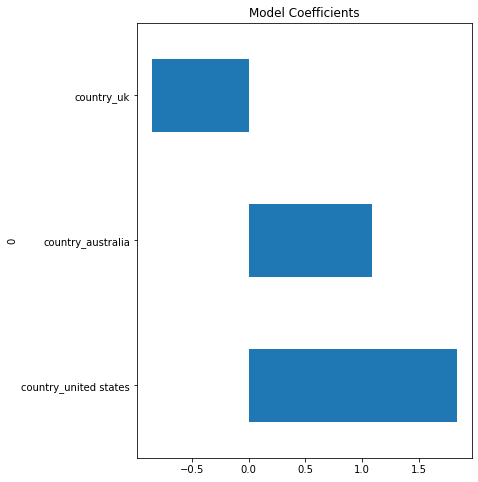

In [175]:
print('Intercept:', model.intercept_)
coef_ = pd.DataFrame(list(zip(X_train.columns, model.coef_[0]))).sort_values(by=1, ascending=False)

coef_.plot(kind='barh', x=0, y=1, figsize=(6, 8), legend=False);
plt.title('Model Coefficients')

------

##### Log Reg Just city column

In [178]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

cv = cross_val_score(model, X_train, y_train)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.8054711246200608
Test Score: 0.708649468892261
Cross Validation Score: [0.70967742 0.74193548 0.76425856 0.73193916 0.71863118]
Mean cross Validation Score: 0.7332883601128419
Standard Deviation of Cross Validation Score: 0.019016075045183555


Text(0.5, 1.0, 'Model Coefficients')

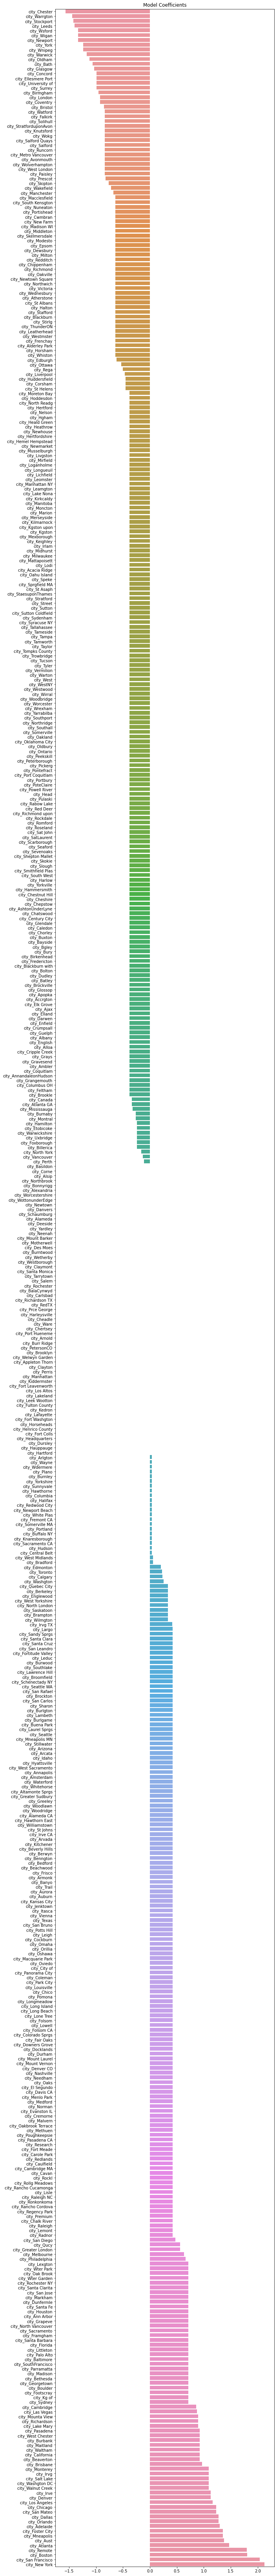

In [192]:
coefs_1 = pd.Series(index=X_train.columns, data=model.coef_[0]).sort_values()
plt.figure(figsize=(10,120))
sns.barplot(x=coefs_1.values, y=coefs_1.index);
plt.title('Model Coefficients')

We can clearly see in the model that the highest indicators of high salary as seen above are mostly US cities, with some exceptions, mainly from Australia, with Adelaide and Brisbane near the top.

On the other hand we can see a lot of Uk cities near the bottom, with London suprisingly having a negative coeficient. 

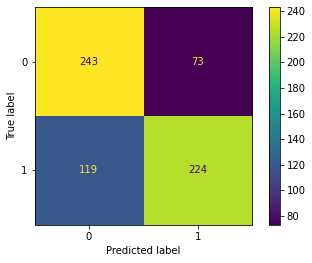

In [195]:
plot_confusion_matrix(model, X_test, y_test);

We have 119 cases where we predicted a low salary (False Negative), yet the salary was high, and likewise we have 73 cases where we predicted a high salary and it was low (False Postive). High = above median , low = below median salary.

In [196]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72       316
           1       0.75      0.65      0.70       343

    accuracy                           0.71       659
   macro avg       0.71      0.71      0.71       659
weighted avg       0.71      0.71      0.71       659



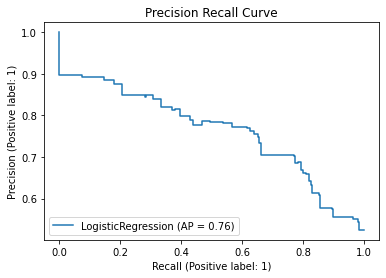

In [207]:
plot_precision_recall_curve(model, X_test, y_test);
plt.title('Precision Recall Curve')
plt.show()

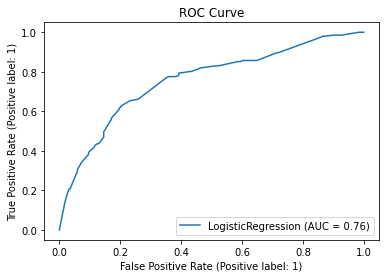

In [208]:
plot_roc_curve(model, X_test, y_test);
plt.title('ROC Curve')
plt.show()

----

##### Log Reg City and Country Columns

In [269]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

cv = cross_val_score(model, X_train, y_train)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.7758358662613982
Test Score: 0.7526555386949925
Cross Validation Score: [0.73055028 0.77039848 0.78707224 0.76235741 0.76806084]
Mean cross Validation Score: 0.7636878521799988
Standard Deviation of Cross Validation Score: 0.018497857940842737


###### We can see just by adding the country feature the model already sees considerable improvement to just the city column, however the performance of these two features is really similar to just the country column on its own.

### Grid Search Logistic Regression - City and Country columns

In [142]:
grid={"C":np.logspace(-3,3,10), "penalty":["l1","l2"], 'solver':['saga']}
model=LogisticRegression(max_iter=1000, verbose=2, n_jobs=-2)
logreg_cv=GridSearchCV(model,grid,cv=5)

logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1

Epoch 1, change: 1.00000000
Epoch 2, change: 0.56431560
Epoch 3, change: 0.23073174
Epoch 4, change: 0.29648003
Epoch 5, change: 0.10741990
Epoch 6, change: 0.10836186
Epoch 7, change: 0.01715551
Epoch 8, change: 0.02474717
Epoch 9, change: 0.02450947
Epoch 10, change: 0.00493470
Epoch 11, change: 0.00436803
Epoch 12, change: 0.00094134
Epoch 13, change: 0.00052087
Epoch 14, change: 0.00054994
Epoch 15, change: 0.00020787
Epoch 1, change: 1.00000000
Epoch 2, change: 0.58099253
Epoch 3, change: 0.34727487
Epoch 4, change: 0.16990589
Epoch 5, change: 0.15507122
Epoch 6, change: 0.09019682
Epoch 7, change: 0.05693165
Epoch 8, change: 0.01631319
Epoch 9, change: 0.00991449
Epoch 10, change: 0.00481439
Epoch 11, change: 0.00480894
Epoch 12, change: 0.00046139
Epoch 13, change: 0.00037656
Epoch 14, change: 0.00041463
Epoch 15, change: 0.00029788
Epoch 16, change: 0.00027916
Epoch 17, change: 0.00026703
Epoch 1, change: 1.00000000
Epoch 2, change: 0.27587431
Epoch 3, change: 0.22966022
Epoch 

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   11.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    9.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.48811018
Epoch 3, change: 0.42949118
Epoch 4, change: 0.22665933
Epoch 5, change: 0.16746406
Epoch 6, change: 0.09633834
Epoch 7, change: 0.03101843
Epoch 8, change: 0.00775868
Epoch 9, change: 0.00760588
Epoch 10, change: 0.00176090
Epoch 11, change: 0.00217046
Epoch 12, change: 0.00138001
Epoch 13, change: 0.00095898
Epoch 14, change: 0.00025405
Epoch 15, change: 0.00010655
Epoch 16, change: 0.00010830
Epoch 1, change: 1.00000000
Epoch 2, change: 0.57031057
Epoch 3, change: 0.40255354
Epoch 4, change: 0.22522595
Epoch 5, change: 0.03027486
Epoch 6, change: 0.04828877
Epoch 7, change: 0.01103677
Epoch 8, change: 0.02055043
Epoch 9, change: 0.02088933
Epoch 10, change: 0.00309599
Epoch 11, change: 0.00139525
Epoch 12, change: 0.00088070
Epoch 13, change: 0.00055002
Epoch 14, change: 0.00022811
Epoch 15, change: 0.00025918
Epoch 1, change: 1.00000000
Epoch 2, change: 0.43865836
Epoch 3, change: 1.90602454
Epoch 4, change: 0.37001687
Epoch 5

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


ch 27, change: 0.00098975
Epoch 28, change: 0.00081127
Epoch 29, change: 0.00073064
Epoch 30, change: 0.00063812
Epoch 31, change: 0.00055732
Epoch 32, change: 0.00042902
Epoch 33, change: 0.00037394
Epoch 34, change: 0.00033045
Epoch 35, change: 0.00026695
Epoch 36, change: 0.00024047
Epoch 37, change: 0.00021003
Epoch 38, change: 0.00016288
Epoch 39, change: 0.00014499
Epoch 40, change: 0.00012500
Epoch 41, change: 0.00010691
Epoch 1, change: 1.00000000
Epoch 2, change: 0.31034390
Epoch 3, change: 0.18246317
Epoch 4, change: 0.15954820
Epoch 5, change: 0.12868913
Epoch 6, change: 0.09520877
Epoch 7, change: 0.11987366
Epoch 8, change: 0.05377554
Epoch 9, change: 0.05087059
Epoch 10, change: 0.05402128
Epoch 11, change: 0.04178987
Epoch 12, change: 0.04112845
Epoch 13, change: 0.03802549
Epoch 14, change: 0.03084038
Epoch 15, change: 0.03046976
Epoch 16, change: 0.02599126
Epoch 17, change: 0.02571161
Epoch 18, change: 0.02544896
Epoch 19, change: 0.02521123
Epoch 20, change: 0.024990

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   30.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32412774
Epoch 3, change: 0.16405520
Epoch 4, change: 0.09761208
Epoch 5, change: 0.23873768
Epoch 6, change: 0.14536462
Epoch 7, change: 0.01983232
Epoch 8, change: 0.04045923
Epoch 9, change: 0.03127768
Epoch 10, change: 0.00391311
Epoch 11, change: 0.00249356
Epoch 12, change: 0.00171205
Epoch 13, change: 0.00115687
Epoch 14, change: 0.00075797
Epoch 1, change: 1.00000000
Epoch 2, change: 0.30112588
Epoch 3, change: 0.20917647
Epoch 4, change: 0.18055196
Epoch 5, change: 0.10748345
Epoch 6, change: 0.05083597
Epoch 7, change: 0.02824410
Epoch 8, change: 0.02170923
Epoch 9, change: 0.00799745
Epoch 10, change: 0.00370986
Epoch 11, change: 0.00490026
Epoch 12, change: 0.00172616
Epoch 13, change: 0.00172564
Epoch 14, change: 0.00088014
Epoch 15, change: 0.00095523
Epoch 16, change: 0.00373780
Epoch 17, change: 0.00301305
Epoch 18, change: 0.00038857
Epoch 19, change: 0.00034323
Epoch 1, change: 1.00000000
Epoch 2, change: 0.30216118
Epoch

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   34.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


 change: 0.00021485
Epoch 537, change: 0.00021489
Epoch 538, change: 0.00021457
Epoch 539, change: 0.00021267
Epoch 540, change: 0.00021280
Epoch 541, change: 0.00021276
Epoch 542, change: 0.00021091
Epoch 543, change: 0.00021108
Epoch 544, change: 0.00020967
Epoch 545, change: 0.00020900
Epoch 546, change: 0.00020928
Epoch 547, change: 0.00020928
Epoch 548, change: 0.00020596
Epoch 549, change: 0.00020724
Epoch 550, change: 0.00020647
Epoch 551, change: 0.00020527
Epoch 552, change: 0.00020537
Epoch 553, change: 0.00020535
Epoch 554, change: 0.00020407
Epoch 555, change: 0.00020276
Epoch 556, change: 0.00020280
Epoch 557, change: 0.00020260
Epoch 558, change: 0.00020260
Epoch 559, change: 0.00020079
Epoch 560, change: 0.00020079
Epoch 561, change: 0.00019947
Epoch 562, change: 0.00019894
Epoch 563, change: 0.00019699
Epoch 564, change: 0.00019720
Epoch 565, change: 0.00019681
Epoch 566, change: 0.00019532
Epoch 567, change: 0.00019538
Epoch 568, change: 0.00019538
Epoch 569, change: 0

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   26.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.98960128
Epoch 3, change: 2.11949866
Epoch 4, change: 0.36915478
Epoch 5, change: 0.62832427
Epoch 6, change: 0.36759161
Epoch 7, change: 0.10132134
Epoch 8, change: 0.13412500
Epoch 9, change: 0.01251590
Epoch 10, change: 0.06866676
Epoch 11, change: 0.02089285
Epoch 12, change: 0.00360476
Epoch 13, change: 0.01089504
Epoch 14, change: 0.00246002
Epoch 15, change: 0.00442777
Epoch 16, change: 0.00088859
Epoch 17, change: 0.00086791
Epoch 18, change: 0.00027193
Epoch 19, change: 0.00018905
Epoch 1, change: 1.00000000
Epoch 2, change: 0.36783520
Epoch 3, change: 0.54295725
Epoch 4, change: 0.19596144
Epoch 5, change: 0.05829022
Epoch 6, change: 0.03707791
Epoch 7, change: 0.02432942
Epoch 8, change: 0.01895070
Epoch 9, change: 0.00943844
Epoch 10, change: 0.00770176
Epoch 11, change: 0.00240006
Epoch 12, change: 0.00151568
Epoch 13, change: 0.00080273
Epoch 14, change: 0.00074651
Epoch 15, change: 0.00023578
Epoch 16, change: 0.00016496
Epo

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   26.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


397, change: 0.00034940
Epoch 398, change: 0.00034703
Epoch 399, change: 0.00034703
Epoch 400, change: 0.00034702
Epoch 401, change: 0.00034551
Epoch 402, change: 0.00034343
Epoch 403, change: 0.00034417
Epoch 404, change: 0.00034275
Epoch 405, change: 0.00034224
Epoch 406, change: 0.00034234
Epoch 407, change: 0.00034234
Epoch 408, change: 0.00033862
Epoch 409, change: 0.00033998
Epoch 410, change: 0.00033996
Epoch 411, change: 0.00033812
Epoch 412, change: 0.00033803
Epoch 413, change: 0.00033813
Epoch 414, change: 0.00033670
Epoch 415, change: 0.00033611
Epoch 416, change: 0.00033614
Epoch 417, change: 0.00033517
Epoch 418, change: 0.00033531
Epoch 419, change: 0.00033531
Epoch 420, change: 0.00033531
Epoch 421, change: 0.00033230
Epoch 422, change: 0.00033390
Epoch 423, change: 0.00033350
Epoch 424, change: 0.00033230
Epoch 425, change: 0.00032881
Epoch 426, change: 0.00032694
Epoch 427, change: 0.00032655
Epoch 428, change: 0.00032655
Epoch 429, change: 0.00032655
Epoch 430, chang

Epoch 146, change: 0.00180686
Epoch 147, change: 0.00179632
Epoch 148, change: 0.00179508
Epoch 149, change: 0.00179336
Epoch 150, change: 0.00178572
Epoch 151, change: 0.00178596
Epoch 152, change: 0.00172463
Epoch 153, change: 0.00167792
Epoch 154, change: 0.00160251
Epoch 155, change: 0.00155715
Epoch 156, change: 0.00155845
Epoch 157, change: 0.00145255
Epoch 158, change: 0.00144729
Epoch 159, change: 0.00144422
Epoch 160, change: 0.00144860
Epoch 161, change: 0.00137793
Epoch 162, change: 0.00139923
Epoch 163, change: 0.00140440
Epoch 164, change: 0.00140557
Epoch 165, change: 0.00135327
Epoch 166, change: 0.00138013
Epoch 167, change: 0.00133295
Epoch 168, change: 0.00135590
Epoch 169, change: 0.00136300
Epoch 170, change: 0.00129716
Epoch 171, change: 0.00132415
Epoch 172, change: 0.00129005
Epoch 173, change: 0.00129872
Epoch 174, change: 0.00128913
Epoch 175, change: 0.00128869
Epoch 176, change: 0.00128142
Epoch 177, change: 0.00128192
Epoch 178, change: 0.00127990
Epoch 179,

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   43.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 o

Epoch 1, change: 1.00000000
Epoch 2, change: 0.42231041
Epoch 3, change: 0.34352932
Epoch 4, change: 0.23523949
Epoch 5, change: 0.03656827
Epoch 6, change: 0.03587587
Epoch 7, change: 0.05299282
Epoch 8, change: 0.00434456
Epoch 9, change: 0.00427662
Epoch 10, change: 0.00143578
Epoch 11, change: 0.00079431
Epoch 12, change: 0.00047383
Epoch 13, change: 0.00263438
Epoch 14, change: 0.00261894
Epoch 15, change: 0.00026593
Epoch 16, change: 0.00020580
Epoch 1, change: 1.00000000
Epoch 2, change: 0.94607776
Epoch 3, change: 0.39735357
Epoch 4, change: 0.85393591
Epoch 5, change: 0.27162254
Epoch 6, change: 0.11321842
Epoch 7, change: 0.14152886
Epoch 8, change: 0.12617295
Epoch 9, change: 0.02630196
Epoch 10, change: 0.04183902
Epoch 11, change: 0.03082325
Epoch 12, change: 0.03022727
Epoch 13, change: 0.01135800
Epoch 14, change: 0.00158653
Epoch 15, change: 0.00162441
Epoch 16, change: 0.00180165
Epoch 17, change: 0.00087398
Epoch 18, change: 0.00074364
Epoch 19, change: 0.00060441
Epo

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   47.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 17 epochs took 1 seconds
convergence after 22 epochs took 1 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.46108686
Epoch 3, change: 0.16123872
Epoch 4, change: 0.21677749
Epoch 5, change: 0.13746870
Epoch 6, change: 0.02523237
Epoch 7, change: 0.02440674
Epoch 8, change: 0.00745141
Epoch 9, change: 0.00804678
Epoch 10, change: 0.00478743
Epoch 11, change: 0.00356736
Epoch 12, change: 0.00394495
Epoch 13, change: 0.00053580
Epoch 14, change: 0.00052342
Epoch 15, change: 0.00029269
Epoch 16, change: 0.00028283
Epoch 1, change: 

Epoch 182, change: 0.00176053
Epoch 183, change: 0.00171345
Epoch 184, change: 0.00171106
Epoch 185, change: 0.00170962
Epoch 186, change: 0.00167707
Epoch 187, change: 0.00167667
Epoch 188, change: 0.00167529
Epoch 189, change: 0.00163807
Epoch 190, change: 0.00163658
Epoch 191, change: 0.00163556
Epoch 192, change: 0.00161196
Epoch 193, change: 0.00161636
Epoch 194, change: 0.00159464
Epoch 195, change: 0.00158945
Epoch 196, change: 0.00159154
Epoch 197, change: 0.00156135
Epoch 198, change: 0.00157179
Epoch 199, change: 0.00155752
Epoch 200, change: 0.00153740
Epoch 201, change: 0.00154060
Epoch 202, change: 0.00153942
Epoch 203, change: 0.00153824
Epoch 204, change: 0.00153708
Epoch 205, change: 0.00153592
Epoch 206, change: 0.00153476
Epoch 207, change: 0.00147043
Epoch 208, change: 0.00146609
Epoch 209, change: 0.00146717
Epoch 210, change: 0.00144535
Epoch 211, change: 0.00144333
Epoch 212, change: 0.00144425
Epoch 213, change: 0.00143332
Epoch 214, change: 0.00141908
Epoch 215,

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   47.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


43
Epoch 466, change: 0.00087367
Epoch 467, change: 0.00087291
Epoch 468, change: 0.00087215
Epoch 469, change: 0.00087139
Epoch 470, change: 0.00087063
Epoch 471, change: 0.00086049
Epoch 472, change: 0.00086040
Epoch 473, change: 0.00085966
Epoch 474, change: 0.00085737
Epoch 475, change: 0.00085188
Epoch 476, change: 0.00085188
Epoch 477, change: 0.00084765
Epoch 478, change: 0.00084643
Epoch 479, change: 0.00084624
Epoch 480, change: 0.00084552
Epoch 481, change: 0.00084204
Epoch 482, change: 0.00084134
Epoch 483, change: 0.00083793
Epoch 484, change: 0.00083715
Epoch 485, change: 0.00083585
Epoch 486, change: 0.00083295
Epoch 487, change: 0.00083226
Epoch 488, change: 0.00083157
Epoch 489, change: 0.00083088
Epoch 490, change: 0.00082377
Epoch 491, change: 0.00082450
Epoch 492, change: 0.00082030
Epoch 493, change: 0.00081985
Epoch 494, change: 0.00081918
Epoch 495, change: 0.00081681
Epoch 496, change: 0.00081337
Epoch 497, change: 0.00081276
Epoch 498, change: 0.00080962
Epoch 4

Epoch 12, change: 0.rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 18 epochs took 1 seconds
convergence after 18 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 344 epochs took 14 seconds
convergence after 41 epochs took 1 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.53420977
Epoch 3, change: 0.33496510
Epoch 4, change: 0.14583411
Epoch 5, change: 0.16085377
Epoch 6, change: 0.04299686
Epoch 7, change: 0.02806175
Epoch 8, change: 0.02200330
Epoch 9, change: 0.01736756
Epoch 10, change: 0.00267180
Epoch 11, chan

04450415
Epoch 13, change: 0.02998755
Epoch 14, change: 0.02686293
Epoch 15, change: 0.02638005
Epoch 16, change: 0.02520410
Epoch 17, change: 0.02337380
Epoch 18, change: 0.02140398
Epoch 19, change: 0.02120351
Epoch 20, change: 0.01859186
Epoch 21, change: 0.01843556
Epoch 22, change: 0.01705738
Epoch 23, change: 0.01692288
Epoch 24, change: 0.01601394
Epoch 25, change: 0.01590540
Epoch 26, change: 0.01431553
Epoch 27, change: 0.01308313
Epoch 28, change: 0.01263945
Epoch 29, change: 0.01272626
Epoch 30, change: 0.01200503
Epoch 31, change: 0.01193795
Epoch 32, change: 0.01187347
Epoch 33, change: 0.01133987
Epoch 34, change: 0.01128358
Epoch 35, change: 0.00996035
Epoch 36, change: 0.00979856
Epoch 37, change: 0.00947535
Epoch 38, change: 0.00951842
Epoch 39, change: 0.00943741
Epoch 40, change: 0.00939782
Epoch 41, change: 0.00935888
Epoch 42, change: 0.00903718
Epoch 43, change: 0.00892886
Epoch 44, change: 0.00823462
Epoch 45, change: 0.00810769
Epoch 46, change: 0.00784371
Epoch

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   48.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


: 0.00046728
Epoch 396, change: 0.00046479
Epoch 397, change: 0.00045268
Epoch 398, change: 0.00045709
Epoch 399, change: 0.00045310
Epoch 400, change: 0.00044968
Epoch 401, change: 0.00044912
Epoch 402, change: 0.00044995
Epoch 403, change: 0.00044994
Epoch 404, change: 0.00044994
Epoch 405, change: 0.00044379
Epoch 406, change: 0.00044495
Epoch 407, change: 0.00044540
Epoch 408, change: 0.00044324
Epoch 409, change: 0.00044384
Epoch 410, change: 0.00044383
Epoch 411, change: 0.00044383
Epoch 412, change: 0.00043853
Epoch 413, change: 0.00044042
Epoch 414, change: 0.00044042
Epoch 415, change: 0.00044041
Epoch 416, change: 0.00044041
Epoch 417, change: 0.00044040
Epoch 418, change: 0.00043373
Epoch 419, change: 0.00043416
Epoch 420, change: 0.00043308
Epoch 421, change: 0.00043347
Epoch 422, change: 0.00043347
Epoch 423, change: 0.00043346
Epoch 424, change: 0.00043346
Epoch 425, change: 0.00043345
Epoch 426, change: 0.00042580
Epoch 427, change: 0.00042792
Epoch 428, change: 0.000425

Epoch 168, change: 0.00246952
Epoch 169, change: 0.00244862
Epoch 170, change: 0.00244521
Epoch 171, change: 0.00244187
Epoch 172, change: 0.00241952
Epoch 173, change: 0.00241626
Epoch 174, change: 0.00237863
Epoch 175, change: 0.00237759
Epoch 176, change: 0.00235318
Epoch 177, change: 0.00235741
Epoch 178, change: 0.00235431
Epoch 179, change: 0.00232263
Epoch 180, change: 0.00230929
Epoch 181, change: 0.00230868
Epoch 182, change: 0.00229406
Epoch 183, change: 0.00228087
Epoch 184, change: 0.00228392
Epoch 185, change: 0.00228108
Epoch 186, change: 0.00225477
Epoch 187, change: 0.00225201
Epoch 188, change: 0.00223897
Epoch 189, change: 0.00221656
Epoch 190, change: 0.00221228
Epoch 191, change: 0.00219965
Epoch 192, change: 0.00219704
Epoch 193, change: 0.00217084
Epoch 194, change: 0.00217136
Epoch 195, change: 0.00216678
Epoch 196, change: 0.00215072
Epoch 197, change: 0.00214827
Epoch 198, change: 0.00214390
Epoch 199, change: 0.00212159
Epoch 200, change: 0.00210568
Epoch 201,

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   48.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.15884603
Epoch 3, change: 0.20809283
Epoch 4, change: 0.15193355
Epoch 5, change: 0.03157760
Epoch 6, change: 0.04086525
Epoch 7, change: 0.03256067
Epoch 8, change: 0.01019847
Epoch 9, change: 0.00277759
Epoch 10, change: 0.00355032
Epoch 11, change: 0.00220355
Epoch 12, change: 0.00175341
Epoch 13, change: 0.00727832
Epoch 14, change: 0.00291682
Epoch 15, change: 0.00049605
Epoch 16, change: 0.00019137
Epoch 17, change: 0.00014805
Epoch 18, change: 0.00029107
Epoch 1, change: 1.00000000
Epoch 2, change: 0.25357648
Epoch 3, change: 0.13349861
Epoch 4, change: 0.16789187
Epoch 5, change: 0.14358654
Epoch 6, change: 0.08963835
Epoch 7, change: 0.02737459
Epoch 8, change: 0.01679705
Epoch 9, change: 0.01141376
Epoch 10, change: 0.00922395
Epoch 11, change: 0.00474141
Epoch 12, change: 0.00533226
Epoch 13, change: 0.00479590
Epoch 14, change: 0.00055095
Epoch 15, change: 0.00056072
Epoch 16, change: 0.00022270
Epoch 17, change: 0.00018898
Epo

Epconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resc

och 403, change: 0.00067326
Epoch 404, change: 0.00065803
Epoch 405, change: 0.00067072
Epoch 406, change: 0.00065407
Epoch 407, change: 0.00065929
Epoch 408, change: 0.00066382
Epoch 409, change: 0.00065552
Epoch 410, change: 0.00064637
Epoch 411, change: 0.00065298
Epoch 412, change: 0.00064644
Epoch 413, change: 0.00064129
Epoch 414, change: 0.00067465
Epoch 415, change: 0.00063642
Epoch 416, change: 0.00065484
Epoch 417, change: 0.00064504
Epoch 418, change: 0.00065212
Epoch 419, change: 0.00064664
Epoch 420, change: 0.00063068
Epoch 421, change: 0.00066334
Epoch 422, change: 0.00063804
Epoch 423, change: 0.00065159
Epoch 424, change: 0.00063350
Epoch 425, change: 0.00063906
Epoch 426, change: 0.00064578
Epoch 427, change: 0.00063295
Epoch 428, change: 0.00063492
Epoch 429, change: 0.00062769
Epoch 430, change: 0.00065262
Epoch 431, change: 0.00062622
Epoch 432, change: 0.00062833
Epoch 433, change: 0.00064411
Epoch 434, change: 0.00063723
Epoch 435, change: 0.00063099
Epoch 436, c

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   47.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


0061322
Epoch 562, change: 0.00061324
Epoch 563, change: 0.00061287
Epoch 564, change: 0.00061182
Epoch 565, change: 0.00060908
Epoch 566, change: 0.00060706
Epoch 567, change: 0.00060647
Epoch 568, change: 0.00060631
Epoch 569, change: 0.00060594
Epoch 570, change: 0.00060171
Epoch 571, change: 0.00060197
Epoch 572, change: 0.00060161
Epoch 573, change: 0.00059889
Epoch 574, change: 0.00059853
Epoch 575, change: 0.00059524
Epoch 576, change: 0.00059533
Epoch 577, change: 0.00059277
Epoch 578, change: 0.00059261
Epoch 579, change: 0.00059006
Epoch 580, change: 0.00058904
Epoch 581, change: 0.00058874
Epoch 582, change: 0.00058823
Epoch 583, change: 0.00058523
Epoch 584, change: 0.00058535
Epoch 585, change: 0.00058218
Epoch 586, change: 0.00058296
Epoch 587, change: 0.00058144
Epoch 588, change: 0.00058107
Epoch 589, change: 0.00057775
Epoch 590, change: 0.00057856
Epoch 591, change: 0.00057721
Epoch 592, change: 0.00057688
Epoch 593, change: 0.00057479
Epoch 594, change: 0.00057446
Ep

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    9.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


0.00051743
Epoch 715, change: 0.00051708
Epoch 716, change: 0.00051516
Epoch 717, change: 0.00051564
Epoch 718, change: 0.00051538
Epoch 719, change: 0.00051143
Epoch 720, change: 0.00051230
Epoch 721, change: 0.00051203
Epoch 722, change: 0.00050971
Epoch 723, change: 0.00050859
Epoch 724, change: 0.00050850
Epoch 725, change: 0.00050635
Epoch 726, change: 0.00050650
Epoch 727, change: 0.00050568
Epoch 728, change: 0.00050470
Epoch 729, change: 0.00050365
Epoch 730, change: 0.00050281
Epoch 731, change: 0.00050255
Epoch 732, change: 0.00050230
Epoch 733, change: 0.00049789
Epoch 734, change: 0.00049802
Epoch 735, change: 0.00049806
Epoch 736, change: 0.00049767
Epoch 737, change: 0.00049742
Epoch 738, change: 0.00049520
Epoch 739, change: 0.00049328
Epoch 740, change: 0.00049323
Epoch 741, change: 0.00049297
Epoch 742, change: 0.00048958
Epoch 743, change: 0.00049074
Epoch 744, change: 0.00049050
Epoch 745, change: 0.00048875
Epoch 746, change: 0.00048651
Epoch 747, change: 0.00048720

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    8.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    9.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   10.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 1 seconds
convergence after 21 epochs took 0 seconds
convergence after 31 epochs took 1 seconds
convergence after 21 epochs took 1 seconds
convergence after 40 epochs took 1 seconds
convergence after 801 epochs took 35 seconds
max_iter reached after 44 seconds
och 693, change: 0.00019671
Epoch 694, change: 0.00019702
Epoch 695, change: 0.00019587
Epoch 696, change: 0.00019623
Epoch 697, change: 0.00019555
Epoch 698, change: 0.00019563
Epoch 699, change: 0.00019563
Epoch 700, change: 0.00019436
Epoch 701, change: 0.00019449
Epoch 702, change: 0.00019405
Epoch 703, change: 0.00019386
Epoch 704, change: 0.00019350
Epoch 705, change: 0.00019368
Epoch 706, change: 0.00019290
Epoch 707, change: 0.00019276
Epoch 708, change: 0.00019240
Epoch 709, change: 0.00019221
Epoch 710, change: 0.0001922

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   53.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


ange: 0.00164304
Epoch 112, change: 0.00163713
Epoch 113, change: 0.00160232
Epoch 114, change: 0.00158816
Epoch 115, change: 0.00153783
Epoch 116, change: 0.00152737
Epoch 117, change: 0.00148948
Epoch 118, change: 0.00148226
Epoch 119, change: 0.00144303
Epoch 120, change: 0.00142572
Epoch 121, change: 0.00139635
Epoch 122, change: 0.00139011
Epoch 123, change: 0.00137818
Epoch 124, change: 0.00136636
Epoch 125, change: 0.00135465
Epoch 126, change: 0.00134305
Epoch 127, change: 0.00133155
Epoch 128, change: 0.00125425
Epoch 129, change: 0.00123545
Epoch 130, change: 0.00122717
Epoch 131, change: 0.00121667
Epoch 132, change: 0.00120626
Epoch 133, change: 0.00119595
Epoch 134, change: 0.00118573
Epoch 135, change: 0.00112795
Epoch 136, change: 0.00109380
Epoch 137, change: 0.00108446
Epoch 138, change: 0.00105942
Epoch 139, change: 0.00105537
Epoch 140, change: 0.00102635
Epoch 141, change: 0.00102390
Epoch 142, change: 0.00101517
Epoch 143, change: 0.00100652
Epoch 144, change: 0.00

Epoch 323, change: 0.00094030
Epoch 324, change: 0.00093108
Epoch 325, change: 0.00092896
Epoch 326, change: 0.00092831
Epoch 327, change: 0.00092776
Epoch 328, change: 0.00091608
Epoch 329, change: 0.00091834
Epoch 330, change: 0.00090900
Epoch 331, change: 0.00090710
Epoch 332, change: 0.00090354
Epoch 333, change: 0.00090330
Epoch 334, change: 0.00089460
Epoch 335, change: 0.00089159
Epoch 336, change: 0.00089070
Epoch 337, change: 0.00088317
Epoch 338, change: 0.00088488
Epoch 339, change: 0.00087685
Epoch 340, change: 0.00087366
Epoch 341, change: 0.00087435
Epoch 342, change: 0.00086694
Epoch 343, change: 0.00086470
Epoch 344, change: 0.00086415
Epoch 345, change: 0.00085596
Epoch 346, change: 0.00085541
Epoch 347, change: 0.00085159
Epoch 348, change: 0.00084748
Epoch 349, change: 0.00084459
Epoch 350, change: 0.00084028
Epoch 351, change: 0.00083919
Epoch 352, change: 0.00083419
Epoch 353, change: 0.00083116
Epoch 354, change: 0.00082855
Epoch 355, change: 0.00082822
Epoch 356,

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   53.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


 change: 0.00015390
Epoch 265, change: 0.00014998
Epoch 266, change: 0.00014843
Epoch 267, change: 0.00014689
Epoch 268, change: 0.00014527
Epoch 269, change: 0.00014413
Epoch 270, change: 0.00014233
Epoch 271, change: 0.00013822
Epoch 272, change: 0.00013805
Epoch 273, change: 0.00013694
Epoch 274, change: 0.00013514
Epoch 275, change: 0.00013194
Epoch 276, change: 0.00013110
Epoch 277, change: 0.00013000
Epoch 278, change: 0.00012826
Epoch 279, change: 0.00012519
Epoch 280, change: 0.00012472
Epoch 281, change: 0.00012316
Epoch 282, change: 0.00012197
Epoch 283, change: 0.00012110
Epoch 284, change: 0.00011734
Epoch 285, change: 0.00011676
Epoch 286, change: 0.00011559
Epoch 287, change: 0.00011373
Epoch 288, change: 0.00011280
Epoch 289, change: 0.00011130
Epoch 290, change: 0.00010905
Epoch 291, change: 0.00010812
Epoch 292, change: 0.00010638
Epoch 293, change: 0.00010583
Epoch 294, change: 0.00010494
Epoch 295, change: 0.00010405
Epoch 296, change: 0.00010002
Epoch 297, change: 0

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   55.0s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


949, change: 0.00029830
Epoch 950, change: 0.00029814
Epoch 951, change: 0.00029759
Epoch 952, change: 0.00029772
Epoch 953, change: 0.00029764
Epoch 954, change: 0.00029749
Epoch 955, change: 0.00029748
Epoch 956, change: 0.00029706
Epoch 957, change: 0.00029690
Epoch 958, change: 0.00029689
Epoch 959, change: 0.00029683
Epoch 960, change: 0.00029653
Epoch 961, change: 0.00029663
Epoch 962, change: 0.00029633
Epoch 963, change: 0.00029632
Epoch 964, change: 0.00029600
Epoch 965, change: 0.00029600
Epoch 966, change: 0.00029587
Epoch 967, change: 0.00029549
Epoch 968, change: 0.00029561
Epoch 969, change: 0.00029559
Epoch 970, change: 0.00029515
Epoch 971, change: 0.00029487
Epoch 972, change: 0.00029493
Epoch 973, change: 0.00029443
Epoch 974, change: 0.00029447
Epoch 975, change: 0.00029440
Epoch 976, change: 0.00029405
Epoch 977, change: 0.00029409
Epoch 978, change: 0.00029382
Epoch 979, change: 0.00029370
Epoch 980, change: 0.00029367
Epoch 981, change: 0.00029368
Epoch 982, chang

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   54.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


change: 0.00035379
Epoch 729, change: 0.00034754
Epoch 730, change: 0.00035250
Epoch 731, change: 0.00035342
Epoch 732, change: 0.00035064
Epoch 733, change: 0.00034980
Epoch 734, change: 0.00034629
Epoch 735, change: 0.00035031
Epoch 736, change: 0.00035129
Epoch 737, change: 0.00035083
Epoch 738, change: 0.00034856
Epoch 739, change: 0.00035310
Epoch 740, change: 0.00034733
Epoch 741, change: 0.00034732
Epoch 742, change: 0.00034999
Epoch 743, change: 0.00034910
Epoch 744, change: 0.00034966
Epoch 745, change: 0.00035201
Epoch 746, change: 0.00034750
Epoch 747, change: 0.00034833
Epoch 748, change: 0.00034667
Epoch 749, change: 0.00034890
Epoch 750, change: 0.00034923
Epoch 751, change: 0.00034662
Epoch 752, change: 0.00034966
Epoch 753, change: 0.00034396
Epoch 754, change: 0.00034587
Epoch 755, change: 0.00035088
Epoch 756, change: 0.00034804
Epoch 757, change: 0.00034893
Epoch 758, change: 0.00034691
Epoch 759, change: 0.00034288
Epoch 760, change: 0.00035034
Epoch 761, change: 0.

Epoch 17, change: 0.02635606
Epoch 18, change: 0.02002212
Epoch 19, change: 0.02067571
Epoch 20, change: 0.01713401
Epoch 21, change: 0.01826290
Epoch 22, change: 0.01662711
Epoch 23, change: 0.01544011
Epoch 24, change: 0.01532778
Epoch 25, change: 0.01416691
Epoch 26, change: 0.01407015
Epoch 27, change: 0.01397968
Epoch 28, change: 0.01163299
Epoch 29, change: 0.01154889
Epoch 30, change: 0.01083762
Epoch 31, change: 0.01077550
Epoch 32, change: 0.01060244
Epoch 33, change: 0.01054576
Epoch 34, change: 0.00945759
Epoch 35, change: 0.00884880
Epoch 36, change: 0.00891380
Epoch 37, change: 0.00879214
Epoch 38, change: 0.00908099
Epoch 39, change: 0.00814445
Epoch 40, change: 0.00810814
Epoch 41, change: 0.00763924
Epoch 42, change: 0.00751338
Epoch 43, change: 0.00714473
Epoch 44, change: 0.00716391
Epoch 45, change: 0.00717557
Epoch 46, change: 0.00717677
Epoch 47, change: 0.00687344
Epoch 48, change: 0.00702890
Epoch 49, change: 0.00640429
Epoch 50, change: 0.00646113
Epoch 51, chan

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   53.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


11
Epoch 499, change: 0.00080216
Epoch 500, change: 0.00079927
Epoch 501, change: 0.00079920
Epoch 502, change: 0.00079871
Epoch 503, change: 0.00079807
Epoch 504, change: 0.00079108
Epoch 505, change: 0.00078713
Epoch 506, change: 0.00078704
Epoch 507, change: 0.00078334
Epoch 508, change: 0.00078168
Epoch 509, change: 0.00077858
Epoch 510, change: 0.00077859
Epoch 511, change: 0.00077798
Epoch 512, change: 0.00077535
Epoch 513, change: 0.00077018
Epoch 514, change: 0.00077062
Epoch 515, change: 0.00076683
Epoch 516, change: 0.00076663
Epoch 517, change: 0.00076605
Epoch 518, change: 0.00076213
Epoch 519, change: 0.00076155
Epoch 520, change: 0.00075551
Epoch 521, change: 0.00075682
Epoch 522, change: 0.00075321
Epoch 523, change: 0.00075264
Epoch 524, change: 0.00074677
Epoch 525, change: 0.00074783
Epoch 526, change: 0.00074727
Epoch 527, change: 0.00074671
Epoch 528, change: 0.00074616
Epoch 529, change: 0.00073844
Epoch 530, change: 0.00073811
Epoch 531, change: 0.00073757
Epoch 5

Epoch 46, change: 0.00737898
Epoch 47, change: 0.00727163
Epoch 48, change: 0.00722141
Epoch 49, change: 0.00694957
Epoch 50, change: 0.00698233
Epoch 51, change: 0.00683865
Epoch 52, change: 0.00659573
Epoch 53, change: 0.00658494
Epoch 54, change: 0.00655495
Epoch 55, change: 0.00631108
Epoch 56, change: 0.00634640
Epoch 57, change: 0.00619578
Epoch 58, change: 0.00609601
Epoch 59, change: 0.00598074
Epoch 60, change: 0.00594190
Epoch 61, change: 0.00582177
Epoch 62, change: 0.00573648
Epoch 63, change: 0.00572341
Epoch 64, change: 0.00553581
Epoch 65, change: 0.00556147
Epoch 66, change: 0.00547888
Epoch 67, change: 0.00540613
Epoch 68, change: 0.00531280
Epoch 69, change: 0.00519471
Epoch 70, change: 0.00514624
Epoch 71, change: 0.00509455
Epoch 72, change: 0.00508828
Epoch 73, change: 0.00489101
Epoch 74, change: 0.00491246
Epoch 75, change: 0.00486944
Epoch 76, change: 0.00477954
Epoch 77, change: 0.00477798
Epoch 78, change: 0.00467488
Epoch 79, change: 0.00467916
Epoch 80, chan

Epoch 594, change: 0.0convergence after 349 epochs took 9 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.32317598
Epoch 3, change: 0.16519333
Epoch 4, change: 0.12305039
Epoch 5, change: 0.11004918
Epoch 6, change: 0.12269409
Epoch 7, change: 0.09662629
Epoch 8, change: 0.09753325
Epoch 9, change: 0.05595304
Epoch 10, change: 0.05029004
Epoch 11, change: 0.03832713
Epoch 12, change: 0.04228042
Epoch 13, change: 0.03293119
Epoch 14, change: 0.03044458
Epoch 15, change: 0.03030422
Epoch 16, change: 0.02732745
Epoch 17, change: 0.02575943
Epoch 18, change: 0.02272431
Epoch 19, change: 0.02131538
Epoch 20, change: 0.02128811
Epoch 21, change: 0.02099713
Epoch 22, change: 0.02072179
Epoch 23, change: 0.01447490
Epoch 24, change: 0.01454915
Epoch 25, change: 0.01330941
Epoch 26, change: 0.01312968
Epoch 27, change: 0.01204191
Epoch 28, change: 0.01122601
Epoch 29, change: 0.01109314
Epoch 30, change: 0.01045199
Epoch 31, change: 0.01033138
Epoch 32, change: 0.01021541
Epoch 33, chang

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   25.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   22.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   23.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


och 517, change: 0.00070873
Epoch 518, change: 0.00070823
Epoch 519, change: 0.00070773
Epoch 520, change: 0.00070723
Epoch 521, change: 0.00069858
Epoch 522, change: 0.00069680
Epoch 523, change: 0.00069413
Epoch 524, change: 0.00069418
Epoch 525, change: 0.00069064
Epoch 526, change: 0.00068867
Epoch 527, change: 0.00068822
Epoch 528, change: 0.00068715
Epoch 529, change: 0.00068668
Epoch 530, change: 0.00068278
Epoch 531, change: 0.00068268
Epoch 532, change: 0.00068222
Epoch 533, change: 0.00068171
Epoch 534, change: 0.00067629
Epoch 535, change: 0.00067583
Epoch 536, change: 0.00067538
Epoch 537, change: 0.00067219
Epoch 538, change: 0.00067100
Epoch 539, change: 0.00066936
Epoch 540, change: 0.00066892
Epoch 541, change: 0.00066300
Epoch 542, change: 0.00066376
Epoch 543, change: 0.00066075
Epoch 544, change: 0.00066043
Epoch 545, change: 0.00065771
Epoch 546, change: 0.00065805
Epoch 547, change: 0.00065365
Epoch 548, change: 0.00065457
Epoch 549, change: 0.00065414
Epoch 550, c

Epoch 65, change: 0.00544078
Epoch 66, change: 0.00537281
Epoch 67, change: 0.00535400
Epoch 68, change: 0.00523340
Epoch 69, change: 0.00519769
Epoch 70, change: 0.00517994
Epoch 71, change: 0.00516134
Epoch 72, change: 0.00514300
Epoch 73, change: 0.00510834
Epoch 74, change: 0.00493848
Epoch 75, change: 0.00490357
Epoch 76, change: 0.00484869
Epoch 77, change: 0.00480565
Epoch 78, change: 0.00475506
Epoch 79, change: 0.00474110
Epoch 80, change: 0.00469093
Epoch 81, change: 0.00461618
Epoch 82, change: 0.00461590
Epoch 83, change: 0.00448170
Epoch 84, change: 0.00449030
Epoch 85, change: 0.00447599
Epoch 86, change: 0.00446181
Epoch 87, change: 0.00440288
Epoch 88, change: 0.00431466
Epoch 89, change: 0.00428537
Epoch 90, change: 0.00427208
Epoch 91, change: 0.00425902
Epoch 92, change: 0.00413039
Epoch 93, change: 0.00412248
Epoch 94, change: 0.00411585
Epoch 95, change: 0.00402726
Epoch 96, change: 0.00404902
Epoch 97, change: 0.00394809
Epoch 98, change: 0.00394831
Epoch 99, chan

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   21.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   18.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


0024524
Epoch 595, change: 0.00024473
Epoch 596, change: 0.00024387
Epoch 597, change: 0.00024340
Epoch 598, change: 0.00024290
Epoch 599, change: 0.00024240
Epoch 600, change: 0.00024143
Epoch 601, change: 0.00024078
Epoch 602, change: 0.00024033
Epoch 603, change: 0.00023983
Epoch 604, change: 0.00023934
Epoch 605, change: 0.00023814
Epoch 606, change: 0.00023790
Epoch 607, change: 0.00023708
Epoch 608, change: 0.00023660
Epoch 609, change: 0.00023614
Epoch 610, change: 0.00023531
Epoch 611, change: 0.00023469
Epoch 612, change: 0.00023415
Epoch 613, change: 0.00023355
Epoch 614, change: 0.00023291
Epoch 615, change: 0.00023249
Epoch 616, change: 0.00023173
Epoch 617, change: 0.00023115
Epoch 618, change: 0.00023056
Epoch 619, change: 0.00023010
Epoch 620, change: 0.00022963
Epoch 621, change: 0.00022855
Epoch 622, change: 0.00022835
Epoch 623, change: 0.00022788
Epoch 624, change: 0.00022741
Epoch 625, change: 0.00022695
Epoch 626, change: 0.00022648
Epoch 627, change: 0.00022478
Ep

Epoch 223, charescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling..

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   59.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


42303
Epoch 567, change: 0.00042641
Epoch 568, change: 0.00042639
Epoch 569, change: 0.00042800
Epoch 570, change: 0.00042974
Epoch 571, change: 0.00042895
Epoch 572, change: 0.00043273
Epoch 573, change: 0.00041145
Epoch 574, change: 0.00042074
Epoch 575, change: 0.00042122
Epoch 576, change: 0.00041256
Epoch 577, change: 0.00041861
Epoch 578, change: 0.00041423
Epoch 579, change: 0.00041245
Epoch 580, change: 0.00041603
Epoch 581, change: 0.00041624
Epoch 582, change: 0.00040704
Epoch 583, change: 0.00041375
Epoch 584, change: 0.00041220
Epoch 585, change: 0.00040556
Epoch 586, change: 0.00041020
Epoch 587, change: 0.00041068
Epoch 588, change: 0.00041178
Epoch 589, change: 0.00040546
Epoch 590, change: 0.00040567
Epoch 591, change: 0.00040153
Epoch 592, change: 0.00040592
Epoch 593, change: 0.00040295
Epoch 594, change: 0.00040260
Epoch 595, change: 0.00040105
Epoch 596, change: 0.00040123
Epoch 597, change: 0.00039686
Epoch 598, change: 0.00039873
Epoch 599, change: 0.00039911
Epoc

Epoch 116, change: 0.00382581
Epoch 117, change: 0.00381730
Epoch 118, change: 0.00373348
Epoch 119, change: 0.00374640
Epoch 120, change: 0.00368784
Epoch 121, change: 0.00368745
Epoch 122, change: 0.00367957
Epoch 123, change: 0.00367184
Epoch 124, change: 0.00366409
Epoch 125, change: 0.00354740
Epoch 126, change: 0.00355055
Epoch 127, change: 0.00351288
Epoch 128, change: 0.00351311
Epoch 129, change: 0.00345064
Epoch 130, change: 0.00343454
Epoch 131, change: 0.00343210
Epoch 132, change: 0.00342528
Epoch 133, change: 0.00341866
Epoch 134, change: 0.00334403
Epoch 135, change: 0.00334368
Epoch 136, change: 0.00328000
Epoch 137, change: 0.00331395
Epoch 138, change: 0.00329928
Epoch 139, change: 0.00329312
Epoch 140, change: 0.00328700
Epoch 141, change: 0.00319832
Epoch 142, change: 0.00317380
Epoch 143, change: 0.00315602
Epoch 144, change: 0.00311858
Epoch 145, change: 0.00311744
Epoch 146, change: 0.00308727
Epoch 147, change: 0.00307162
Epoch 148, change: 0.00306621
Epoch 149,

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   59.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


convergence after 773 epochs took 21 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.32425511
Epoch 3, change: 0.18429132
Epoch 4, change: 0.15339501
Epoch 5, change: 0.10782754
Epoch 6, change: 0.09182749
Epoch 7, change: 0.05600908
Epoch 8, change: 0.04598147
Epoch 9, change: 0.04173993
Epoch 10, change: 0.04095655
Epoch 11, change: 0.04030806
Epoch 12, change: 0.03632593
Epoch 13, change: 0.02831323
Epoch 14, change: 0.02705157
Epoch 15, change: 0.02701545
Epoch 16, change: 0.02447454
Epoch 17, change: 0.02242315
Epoch 18, change: 0.02217050
Epoch 19, change: 0.02047160
Epoch 20, change: 0.01729523
Epoch 21, change: 0.01608905
Epoch 22, change: 0.01510242
Epoch 23, change: 0.01563858
Epoch 24, change: 0.01454415
Epoch 25, change: 0.01346208
Epoch 26, change: 0.01268215
Epoch 27, change: 0.01190806
Epoch 28, change: 0.01113357
Epoch 29, change: 0.01131193
Epoch 30, change: 0.01042421
Epoch 31, change: 0.01023937
Epoch 32, change: 0.01016675
Epoch 33, change: 0.00907138
Epoch 3

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


 0.00049299
Epoch 770, change: 0.00049207
Epoch 771, change: 0.00049104
Epoch 772, change: 0.00048961
Epoch 773, change: 0.00048905
Epoch 774, change: 0.00048830
Epoch 775, change: 0.00048722
Epoch 776, change: 0.00048632
Epoch 777, change: 0.00048650
Epoch 778, change: 0.00048626
Epoch 779, change: 0.00048587
Epoch 780, change: 0.00048564
Epoch 781, change: 0.00048307
Epoch 782, change: 0.00048283
Epoch 783, change: 0.00048260
Epoch 784, change: 0.00048237
Epoch 785, change: 0.00048214
Epoch 786, change: 0.00047756
Epoch 787, change: 0.00047832
Epoch 788, change: 0.00047809
Epoch 789, change: 0.00047786
Epoch 790, change: 0.00047619
Epoch 791, change: 0.00047474
Epoch 792, change: 0.00047473
Epoch 793, change: 0.00047451
Epoch 794, change: 0.00047120
Epoch 795, change: 0.00047138
Epoch 796, change: 0.00047146
Epoch 797, change: 0.00047065
Epoch 798, change: 0.00046945
Epoch 799, change: 0.00046869
Epoch 800, change: 0.00046765
Epoch 801, change: 0.00046707
Epoch 802, change: 0.0004670

Epoch 319convergence after 330 epochs took 9 seconds
max_iter reached after 53 seconds
convergence after 840 epochs took 23 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.35079370
Epoch 3, change: 0.15803370
Epoch 4, change: 0.16494333
Epoch 5, change: 0.12642905
Epoch 6, change: 0.07329824
Epoch 7, change: 0.09627473
Epoch 8, change: 0.09339181
Epoch 9, change: 0.06596276
Epoch 10, change: 0.06458658
Epoch 11, change: 0.04681519
Epoch 12, change: 0.04782639
Epoch 13, change: 0.04720543
Epoch 14, change: 0.04636566
Epoch 15, change: 0.02962432
Epoch 16, change: 0.03081645
Epoch 17, change: 0.03049069
Epoch 18, change: 0.02698561
Epoch 19, change: 0.02446538
Epoch 20, change: 0.02372497
Epoch 21, change: 0.02158674
Epoch 22, change: 0.02152017
Epoch 23, change: 0.01793937
Epoch 24, change: 0.01731007
Epoch 25, change: 0.01768477
Epoch 26, change: 0.01427771
Epoch 27, change: 0.01442044
Epoch 28, change: 0.01470775
Epoch 29, change: 0.01453106
Epoch 30, change: 0.01113984
Epoch 3

convergence after 20 epochs took 1 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 17 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 16 epochs took 0 seconds
convergence a

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   59.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   28.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(

ange: 0.00029156
Epoch 866, change: 0.00029150
Epoch 867, change: 0.00028992
Epoch 868, change: 0.00028990
Epoch 869, change: 0.00028945
Epoch 870, change: 0.00028910
Epoch 871, change: 0.00028903
Epoch 872, change: 0.00028774
Epoch 873, change: 0.00028761
Epoch 874, change: 0.00028770
Epoch 875, change: 0.00028665
Epoch 876, change: 0.00028665
Epoch 877, change: 0.00028659
Epoch 878, change: 0.00028517
Epoch 879, change: 0.00028506
Epoch 880, change: 0.00028486
Epoch 881, change: 0.00028485
Epoch 882, change: 0.00028478
Epoch 883, change: 0.00028356
Epoch 884, change: 0.00028348
Epoch 885, change: 0.00028277
Epoch 886, change: 0.00028231
Epoch 887, change: 0.00028240
Epoch 888, change: 0.00028168
Epoch 889, change: 0.00028135
Epoch 890, change: 0.00028138
Epoch 891, change: 0.00028033
Epoch 892, change: 0.00028023
Epoch 893, change: 0.00027958
Epoch 894, change: 0.00027976
Epoch 895, change: 0.00027888
Epoch 896, change: 0.00027910
Epoch 897, change: 0.00027904
Epoch 898, change: 0.00

Epoch 415, change: 0.00092265
Epoch 416, change: 0.00091967
Epoch 417, change: 0.00091345
Epoch 418, change: 0.00091412
Epoch 419, change: 0.00091293
Epoch 420, change: 0.00090147
Epoch 421, change: 0.00089969
Epoch 422, change: 0.00089735
Epoch 423, change: 0.00089406
Epoch 424, change: 0.00089371
Epoch 425, change: 0.00089032
Epoch 426, change: 0.00088722
Epoch 427, change: 0.00088507
Epoch 428, change: 0.00088393
Epoch 429, change: 0.00087501
Epoch 430, change: 0.00087250
Epoch 431, change: 0.00087147
Epoch 432, change: 0.00087037
Epoch 433, change: 0.00086636
Epoch 434, change: 0.00086274
Epoch 435, change: 0.00086165
Epoch 436, change: 0.00085384
Epoch 437, change: 0.00085325
Epoch 438, change: 0.00084816
Epoch 439, change: 0.00084689
Epoch 440, change: 0.00084584
Epoch 441, change: 0.00083907
Epoch 442, change: 0.00083702
Epoch 443, change: 0.00083326
Epoch 444, change: 0.00083277
Epoch 445, change: 0.00082747
Epoch 446, change: 0.00082804
Epoch 447, change: 0.00082414
Epoch 448,

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   27.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


convergence after 645 epochs took 18 seconds
max_iter reached after 61 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.35495491
Epoch 3, change: 0.16885681
Epoch 4, change: 0.14074928
Epoch 5, change: 0.08613994
Epoch 6, change: 0.11887349
Epoch 7, change: 0.06905939
Epoch 8, change: 0.05796649
Epoch 9, change: 0.05673855
Epoch 10, change: 0.04229331
Epoch 11, change: 0.03505954
Epoch 12, change: 0.03339810
Epoch 13, change: 0.02911413
Epoch 14, change: 0.02669887
Epoch 15, change: 0.02707145
Epoch 16, change: 0.02556020
Epoch 17, change: 0.02386975
Epoch 18, change: 0.02360334
Epoch 19, change: 0.01768669
Epoch 20, change: 0.01834166
Epoch 21, change: 0.01816521
Epoch 22, change: 0.01799457
Epoch 23, change: 0.01421367
Epoch 24, change: 0.01471186
Epoch 25, change: 0.01317549
Epoch 26, change: 0.01199634
Epoch 27, change: 0.01175573
Epoch 28, change: 0.01148744
Epoch 29, change: 0.01107251
Epoch 30, change: 0.01099282
Epoch 31, change: 0.00968584
Epoch 32, change: 0.00978970
Ep

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   28.6s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.


convergence after 39 epochs took 2 seconds
tuned hpyerparameters :(best parameters)  {'C': 2.154434690031882, 'penalty': 'l2', 'solver': 'saga'}
accuracy : 0.7933290524599389


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    1.4s finished


In [267]:
log_model = logreg_cv.best_estimator_
log_model.fit(X_train, y_train)

cv = cross_val_score(log_model, X_train, y_train)

print('Training Score:', log_model.score(X_train, y_train))
print('Test Score:',log_model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.


convergence after 33 epochs took 1 seconds


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


Training Score: 0.7864741641337386
Test Score: 0.7481031866464339
Cross Validation Score: [0.73055028 0.77229602 0.78707224 0.76425856 0.76806084]
Mean cross Validation Score: 0.7644475869582471
Standard Deviation of Cross Validation Score: 0.018631110072402667


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.2s finished


Coeficients:

Text(0.5, 1.0, 'Model Coefficients')

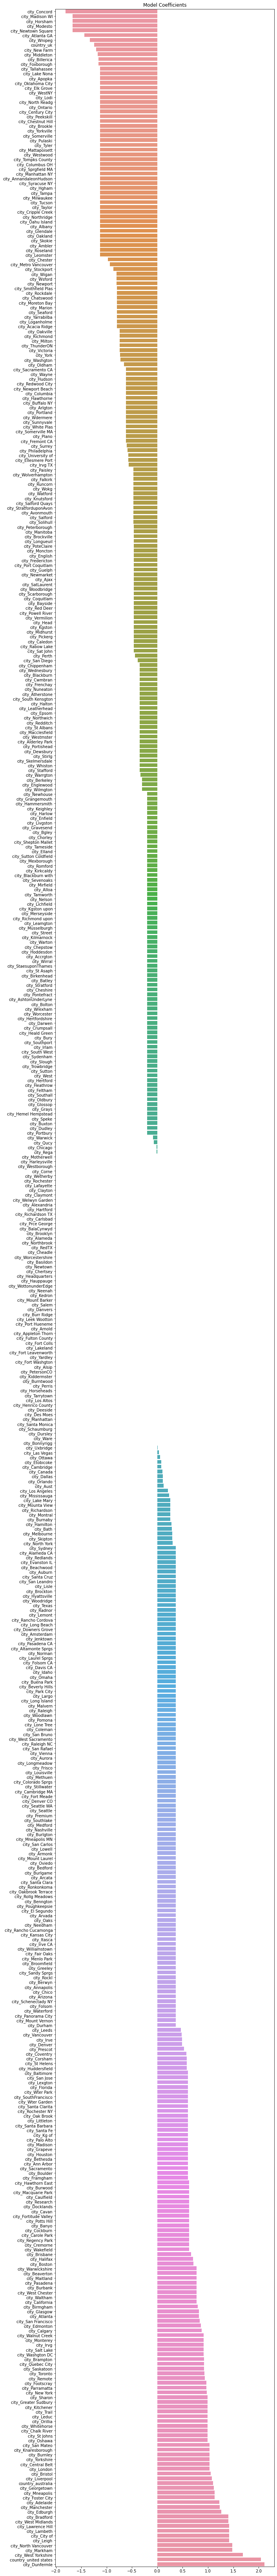

In [268]:
coefs_ = pd.Series(index=X_train.columns, data=log_model.coef_[0]).sort_values()
plt.figure(figsize=(10,120))
sns.barplot(x=coefs_.values, y=coefs_.index);
plt.title('Model Coefficients')

Confuison Matrix

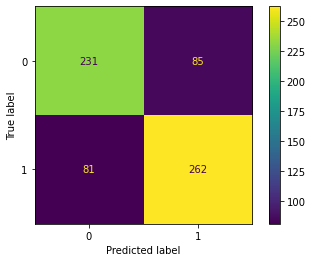

In [270]:
plot_confusion_matrix(log_model, X_test, y_test);

There is a significant improvement, adding the country and city column together, with our False Negative rates having decreases drastically

###### Classification report

In [271]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       316
           1       0.77      0.75      0.76       343

    accuracy                           0.75       659
   macro avg       0.75      0.75      0.75       659
weighted avg       0.75      0.75      0.75       659



-----

### KNN - City and Country columns

In [287]:
y = df_salary.salary_binary
X = pd.get_dummies(df_salary[['city', 'country']], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2632, 536) (2632,)
(659, 536) (659,)


In [288]:
scores = []
max_k = 100
for k in range(1, max_k):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=10)))
    

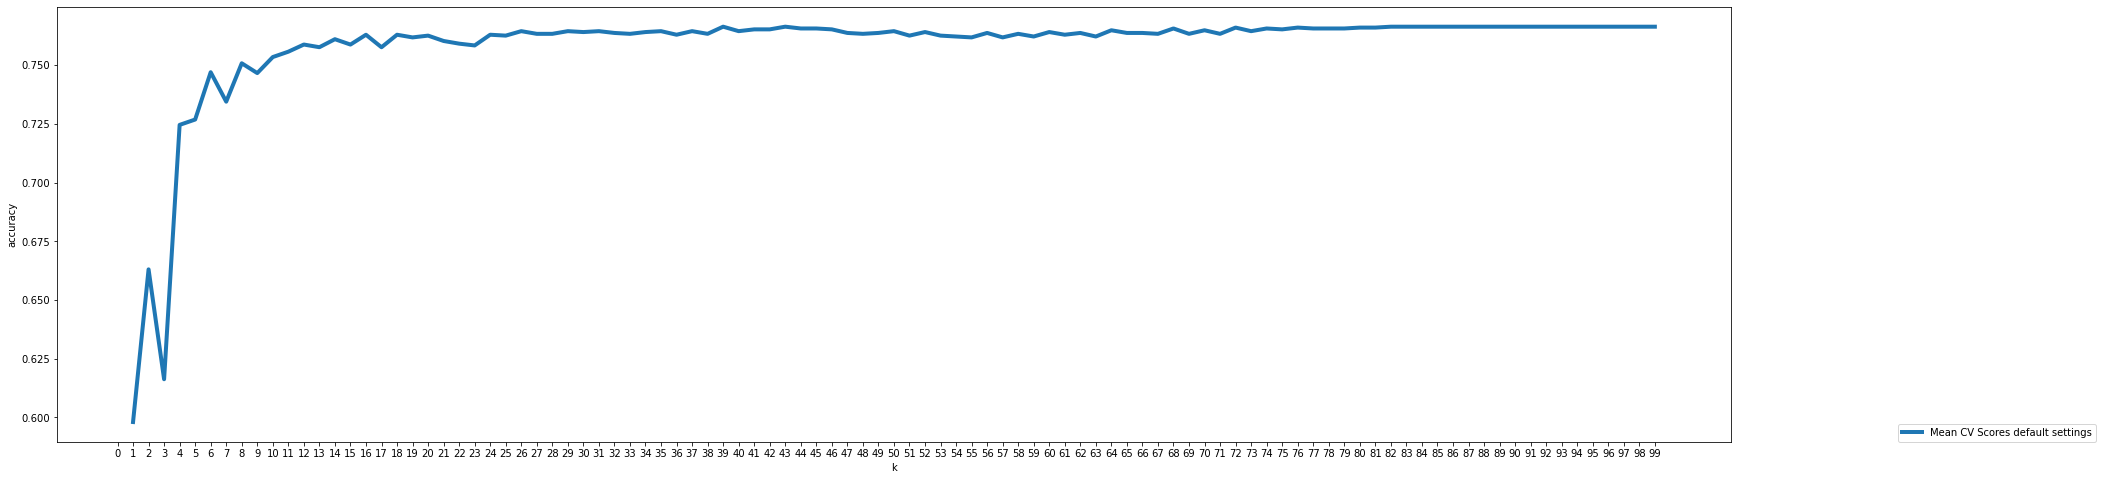

In [289]:
fig, ax = plt.subplots(figsize=(30, 8))
ax.plot(range(1, max_k), scores, label='Mean CV Scores default settings', lw=4)
#ax.hlines(y.value_counts(normalize=True).max(), 1, 25, label='baseline', lw=4)
ax.set_xlabel('k')
plt.xticks(range(0,max_k))
ax.set_ylabel('accuracy')
ax.legend(loc=[1.1, 0])
plt.show()


In [290]:
params = {'n_neighbors': list(range(15,100, 1)), 'metric':['euclidean']}

In [291]:
model = KNeighborsClassifier()
knn_grid = GridSearchCV(model, param_grid=params, verbose=1, cv=5, n_jobs=8)

knn_grid.fit(X_train, y_train)

print(knn_grid.best_score_)
print(knn_grid.best_estimator_)
print(knn_grid.best_params_)

Fitting 5 folds for each of 85 candidates, totalling 425 fits
0.7682477038405207
KNeighborsClassifier(metric='euclidean', n_neighbors=64)
{'metric': 'euclidean', 'n_neighbors': 64}


In [330]:
model = KNeighborsClassifier(n_neighbors=64)
model.fit(X_train, y_train)

cv =cross_val_score(model, X_train, y_train, cv=5)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.7697568389057751
Test Score: 0.7617602427921093
Cross Validation Score: [0.73244782 0.76470588 0.78707224 0.76996198 0.7756654 ]
Mean cross Validation Score: 0.7659706639923233
Standard Deviation of Cross Validation Score: 0.018333444906549486


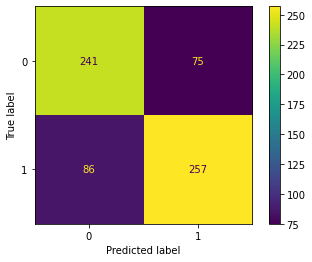

In [294]:
plot_confusion_matrix(model, X_test, y_test);

------

### Decision Tree - City, Country,  remote columns

In [295]:
y = df_salary.salary_binary
X = pd.get_dummies(df_salary[['city', 'country']], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2632, 536) (2632,)
(659, 536) (659,)


In [296]:
# fit the model
params = {'max_depth':[3,4,5,6,7,8,9,10,11,12,13, None]}

regressor = DecisionTreeClassifier()

grid = GridSearchCV(regressor, 
                    param_grid=params, 
                    n_jobs=8, 
                    cv=5, 
                    verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       None]},
             verbose=1)

In [297]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 3}
0.7671070194298742


In [298]:
dtree = DecisionTreeClassifier(max_depth=3)

dtree.fit(X_train, y_train)
cv = cross_val_score(dtree, X_train, y_train, cv=5)

print('Training Score:', dtree.score(X_train, y_train))
print('Test Score:',dtree.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.7693768996960486
Test Score: 0.7526555386949925
Cross Validation Score: [0.73244782 0.77609108 0.7851711  0.77376426 0.76806084]
Mean cross Validation Score: 0.7671070194298742
Standard Deviation of Cross Validation Score: 0.018185232089893564


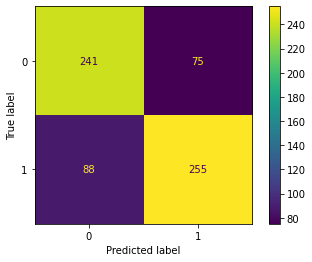

In [299]:
plot_confusion_matrix(dtree, X_test, y_test);

In [300]:
from sklearn.tree import export_graphviz
import graphviz

In [301]:
def plot_dt(dtree, feature_names=None):
    print('Max depth:', dtree.max_depth)
    dot_data = export_graphviz(dtree,
                filled=True,
                rounded=True,
                special_characters=True
                )

    graph = graphviz.Source(dot_data) 

    return  graph

Max depth: 3


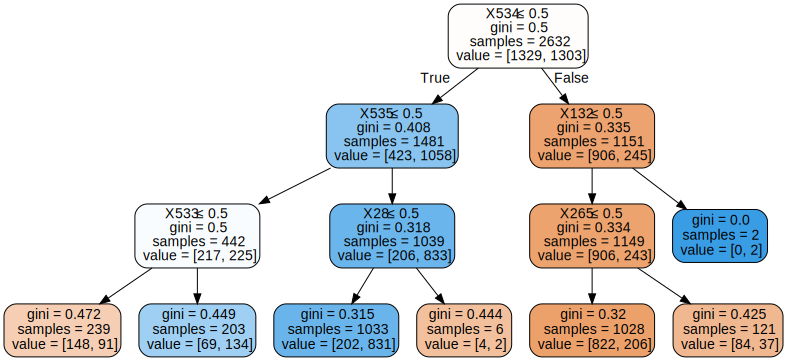

In [302]:
plot_dt(dtree, feature_names=X.columns)

-----

### ADA Boost

In [303]:
base_estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)
model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=5)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.8054711246200608
Test Score: 0.7450682852807283
Cross Validation Score: [0.73624288 0.75901328 0.78707224 0.75855513 0.76235741]
Mean cross Validation Score: 0.7606481915714893
Standard Deviation of Cross Validation Score: 0.01614821848515118


### Gradient Boost

In [305]:
model = GradientBoostingClassifier(
    n_estimators=100,
    criterion='mse',
    loss='deviance',
    #max_depth=3,
    learning_rate=1.0,
    random_state=1)

model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=5)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.8050911854103343
Test Score: 0.7405159332321699
Cross Validation Score: [0.73434535 0.75711575 0.7851711  0.75855513 0.76045627]
Mean cross Validation Score: 0.7591287220149926
Standard Deviation of Cross Validation Score: 0.01611561058478788


-----

# With Full dataset

##### Word Clouds

In [42]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [580]:
text = " ".join(job for job in df_salary.job_title)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 97118 words in the combination of all review.


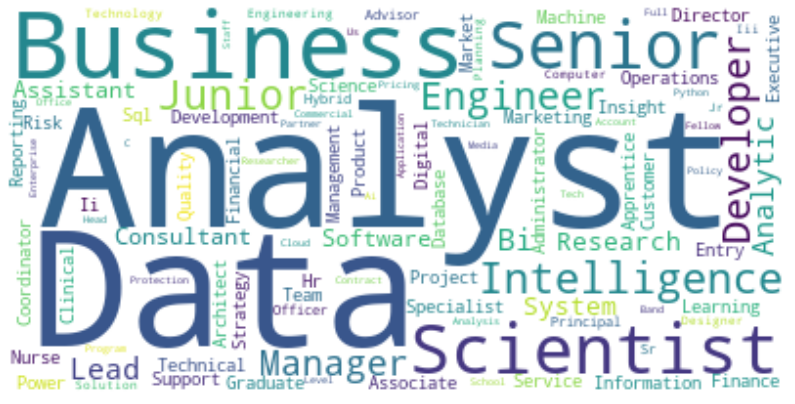

In [585]:
# Generate a word cloud image
wordcloud = WordCloud(collocations = False, max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(14,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

------

##### Creating dummies, splitting the data and using count vectorizer on the job title column.

In [306]:
df_salary.columns

Index(['job_title', 'company', 'location', 'salary', 'country', 'salary_cat',
       'salary_binary', 'remote', 'city'],
      dtype='object')

Dumifying the Categorial columns except the job title, which I will apply a count vectorizer on.

In [438]:
y = df_salary.salary_binary

df_model = df_salary[['job_title', 'company', 'country','city', 'remote']]
X = pd.get_dummies(df_model, columns=['company', 'city', 'country', 'remote'], drop_first=True)


In [439]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2632, 2504) (2632,)
(659, 2504) (659,)


In [440]:
X_train_for_NLP = X_train.pop('job_title')
X_test_for_NLP = X_test.pop('job_title')

In [441]:
cvec = CountVectorizer(stop_words='english')

X_train_text = cvec.fit_transform(X_train_for_NLP)
X_test_text = cvec.transform(X_test_for_NLP)

In [442]:
df_train_text = pd.DataFrame(((X_train_text).toarray()),
                  columns=cvec.get_feature_names())

df_test_text = pd.DataFrame(((X_test_text).toarray()),
                  columns=cvec.get_feature_names())

In [443]:
print(df_train_text.shape)
print(df_test_text.shape)

(2632, 1261)
(659, 1261)


In [444]:
df_train = pd.concat([df_train_text, X_train.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_test_text, X_test.reset_index(drop=True)], axis=1)

------

- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable

### MultinomialNB

In [445]:
model = MultinomialNB()
model.fit(df_train, y_train)

cv = cross_val_score(model, df_train, y_train, cv=5)

print('Training Score:', model.score(df_train, y_train))
print('Test Score:',model.score(df_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.8841185410334347
Test Score: 0.7921092564491654
Cross Validation Score: [0.77798861 0.82163188 0.79277567 0.80418251 0.81558935]
Mean cross Validation Score: 0.8024336043751488
Standard Deviation of Cross Validation Score: 0.01571966564079868


### Logistic Regression

In [446]:
log_model = LogisticRegression()
log_model.fit(df_train, y_train)

cv = cross_val_score(log_model, df_train, y_train, cv=5)

print('Training Score:', log_model.score(df_train, y_train))
print('Test Score:',log_model.score(df_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.9285714285714286
Test Score: 0.8209408194233687
Cross Validation Score: [0.80834915 0.82163188 0.82129278 0.83460076 0.84220532]
Mean cross Validation Score: 0.8256159767967042
Standard Deviation of Cross Validation Score: 0.011735751361167028


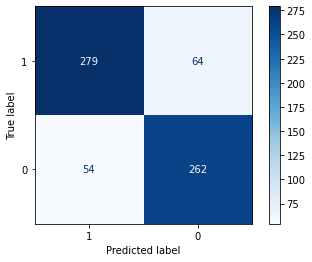

In [447]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

plot_confusion_matrix(log_model,df_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

Immediately we can see that incorporating the whole model drastically improved the scores, we have considerably decreased our False Positives and False Negatives.

##### Classification Report

In [319]:
predictions = log_model.predict(df_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.8037    0.8291    0.8162       316
           1     0.8378    0.8134    0.8254       343

    accuracy                         0.8209       659
   macro avg     0.8208    0.8213    0.8208       659
weighted avg     0.8215    0.8209    0.8210       659



##### Precision Recall

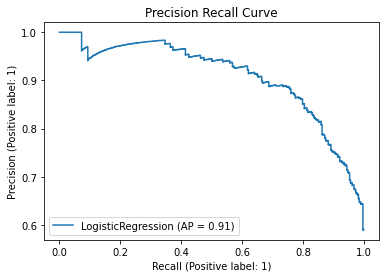

In [322]:
plot_precision_recall_curve(log_model, df_test, y_test);
plt.title('Precision Recall Curve')
plt.show()

##### ROC Curve

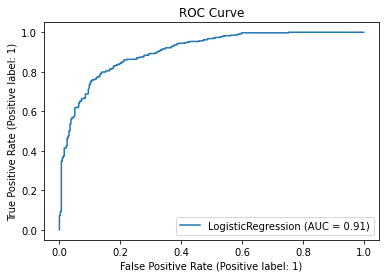

In [324]:
plot_roc_curve(log_model, df_test, y_test);
plt.title('ROC Curve')
plt.show()

In [453]:
pd.Series(index=df_train.columns, data=log_model.coef_[0]).sort_values(ascending=False).head(40)

head                                       2.482932
lead                                       2.347165
country_united states                      2.150352
director                                   1.877955
company_IT Talent Solutions                1.705821
country_australia                          1.629146
scientist                                  1.618966
architect                                  1.574363
azure                                      1.492357
company_Be-IT Resourcing                   1.487969
company_DMC Healthcare                     1.419288
company_Mudano                             1.391426
company_Adria Solutions                    1.360391
company_Hippo Digital Limited              1.329759
company_Lorien                             1.328823
platform                                   1.302555
company_Accenture                          1.269173
company_Reqiva Ltd                         1.268851
senior                                     1.209361
manager     

Text(0.5, 1.0, 'Model Coefficients Head')

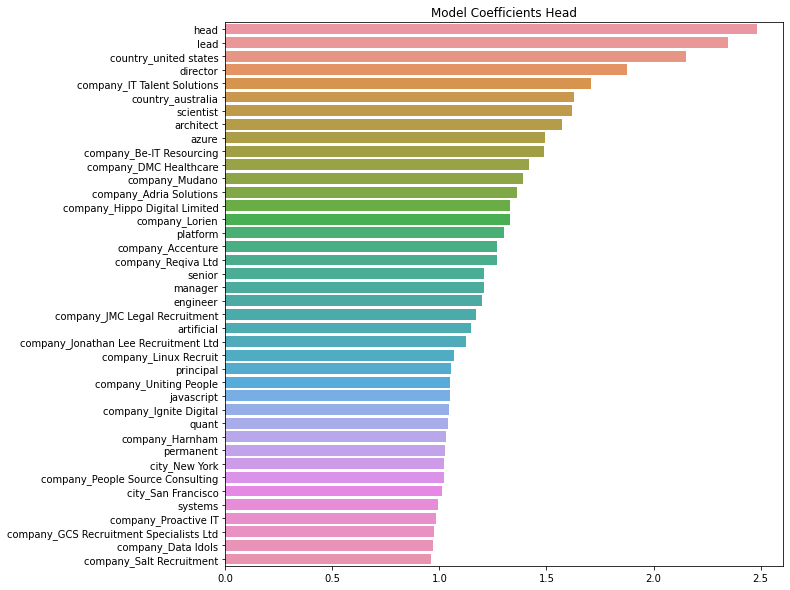

In [461]:
coefs_ = pd.Series(index=df_train.columns, data=log_model.coef_[0]).sort_values(ascending=False).head(40)
plt.figure(figsize=(10,10))
sns.barplot(x=coefs_.values, y=coefs_.index);
plt.title('Model Coefficients Head')

We can see here that when the title contained the words head, lead and director are indicative of an increase in the odds of having a high class salary. Similarly australia an d the us are also following the same trend. It's interesting as well to see azure and architect near the top as there has been recent increase demand in cloud architecture and computing. We also see our first company, IT talent solutions being associated with higher pay.

Text(0.5, 1.0, 'Model Coefficients Tail')

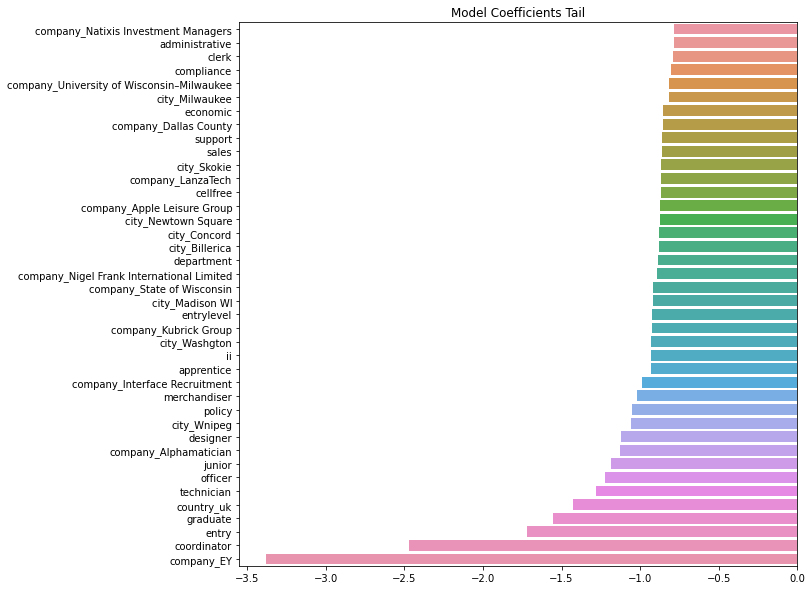

In [460]:
coefs_ = pd.Series(index=df_train.columns, data=log_model.coef_[0]).sort_values(ascending=False).tail(40)
plt.figure(figsize=(10,10))
sns.barplot(x=coefs_.values, y=coefs_.index);
plt.title('Model Coefficients Tail')

On the tail end we can see that having EY (company) in the job increases the odds of having low pay, in the same way that we see entry, graduate and junior which is definitely eithin our expectations. Similarly as seen through out, we can see that the UK continuous to be associated with lower paying jobs.

#### Log Model with grid Search CV

In [413]:
params = {"C":np.logspace(-4,4,100), "penalty":["l1","l2"], 
          'fit_intercept':['True', 'False'], 'solver':['saga', 'liblinear']}

l_model = LogisticRegression()
grid_log_model = GridSearchCV(l_model, 
                    param_grid=params, 
                    n_jobs=9, 
                    cv=5, 
                    verbose=1)

In [414]:
grid_log_model.fit(df_train, y_train)

print("tuned hpyerparameters :(best parameters) ",grid_log_model.best_params_)
print("accuracy :",grid_log_model.best_score_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Us

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 673, in _logistic_regression_path
    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, ve

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 22

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Us

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 673, in _logistic_regression_path
    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, ve

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 673, in _logistic_regression_path
    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, ver

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_o

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logist

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_o

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 673, in _logistic_regression_path
    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, ver

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Us

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'True'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Use

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 673, in _logistic_regression_path
    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, ve

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    w0 = np.zeros(n_features + int(fit_intercept), dtype=X.dtype)
ValueError: invalid literal for int() with base 10: 'False'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Us

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/ariklev

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packa

tuned hpyerparameters :(best parameters)  {'C': 1.3219411484660315, 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.8309362847309905


In [415]:
tuned_log_model =grid_log_model.best_estimator_

In [416]:
tuned_log_model.fit(df_train, y_train)

cv = cross_val_score(tuned_log_model, df_train, y_train, cv=5)

print('Training Score:', tuned_log_model.score(df_train, y_train))
print('Test Score:',tuned_log_model.score(df_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.8848784194528876
Test Score: 0.8103186646433991
Cross Validation Score: [0.81404175 0.82352941 0.83079848 0.83269962 0.85551331]
Mean cross Validation Score: 0.8313165128678726
Standard Deviation of Cross Validation Score: 0.013760252620321274


##### Confusion Matrix

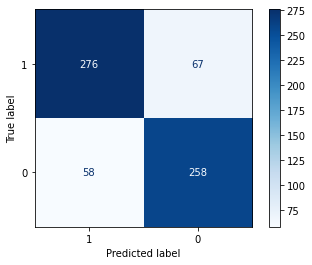

In [417]:
plot_confusion_matrix(tuned_log_model,df_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

##### Classification Report

In [418]:
predictions = tuned_log_model.predict(df_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7938    0.8165    0.8050       316
           1     0.8263    0.8047    0.8154       343

    accuracy                         0.8103       659
   macro avg     0.8101    0.8106    0.8102       659
weighted avg     0.8108    0.8103    0.8104       659



The tuned model is actually slightly worse at predicting the classes, with a slight increase in the false positives and negatives

-------

### Gradient Boost

In [128]:
model = GradientBoostingClassifier(
    n_estimators=100,
    criterion='mse',
    loss='deviance',
    max_depth=3,
    learning_rate=1.0,
    random_state=1)

model.fit(df_train, y_train)
cv = cross_val_score(model, df_train, y_train, cv=5)

print('Training Score:', model.score(df_train, y_train))
print('Test Score:',model.score(df_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.9612462006079028
Test Score: 0.8072837632776935
Cross Validation Score: [0.79127135 0.79316888 0.80988593 0.82129278 0.83079848]
Mean cross Validation Score: 0.8092834828031543
Standard Deviation of Cross Validation Score: 0.015437607073185535


-----

### Random Forest

In [426]:
random_forest_model_basic = RandomForestClassifier(random_state=42)

random_forest_model_basic.fit(df_train, y_train)

cv = cross_val_score(random_forest_model_basic, df_train, y_train, cv=5)

print('Training Score:', random_forest_model_basic.score(df_train, y_train))
print('Test Score:',random_forest_model_basic.score(df_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())

Training Score: 0.9992401215805471
Test Score: 0.8103186646433991
Cross Validation Score: [0.80075901 0.81783681 0.8269962  0.82509506 0.81939163]
Mean cross Validation Score: 0.818015743032157
Standard Deviation of Cross Validation Score: 0.009278847662051814


In [420]:
param_grid = { 
    'n_estimators': list(range(350,450,10)) ,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,9,10,11,12,13,14,15],
    'criterion' :['gini', 'entropy']
}

In [421]:
random_forest_grid = GridSearchCV(random_forest_model, 
                                  param_grid=param_grid, 
                                  n_jobs=9, 
                                  cv=5, 
                                  verbose=1)

In [422]:
random_forest_grid.fit(df_train, y_train)

print("tuned hpyerparameters :(best parameters) ",random_forest_grid.best_params_)
print("accuracy :",random_forest_grid.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 420}
accuracy : 0.8020598696979098


Confusion Matrix

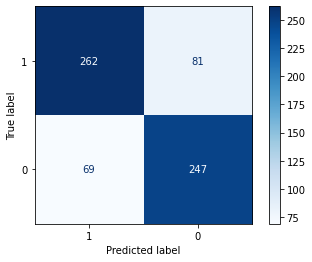

In [424]:
plot_confusion_matrix(random_forest_grid,df_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

Classification Report

In [425]:
predictions = random_forest_grid.predict(df_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7530    0.7816    0.7671       316
           1     0.7915    0.7638    0.7774       343

    accuracy                         0.7724       659
   macro avg     0.7723    0.7727    0.7723       659
weighted avg     0.7731    0.7724    0.7725       659



Random Forest also noticeably worse at making predictions than the logistic regression

------

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [361]:
predictions =log_model.predict(df_test)

In [363]:
Y_pp = pd.DataFrame(log_model.predict_proba(df_test), 
             columns=['class_0_pp', 'class_1_pp'])

Y_pp['model_predictions'] = predictions

Y_pp.head()

class_0_pp  class_1_pp  model_predictions
0    0.266138    0.733862                  1
1    0.204049    0.795951                  1
2    0.932169    0.067831                  0
3    0.117905    0.882095                  1
4    0.810401    0.189599                  0

The above grapgh shows the models interpretation of belonging to one category or the other, as a base, it takes it at 50%. If class_0 is higher than 0.5, then the model would predict a 0. (Below mean salary) and viceversa.

The function below will slightly tweek the threshold at which one category is predicted over the other

In [372]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

We can see that if we isntantiate the model at 0.8 as below then the thresshold for belonging to class 1 will increase. This means that the False positves will decrease and the model will predict less jobs to belong to the high salary category.

This however will greatly decrease the overall accuracy of the model.

In [370]:
Y_pp['y_pred_10'] = Y_pp.class_1_pp.apply(predict_at_threshold, args=[0.8])
Y_pp


class_0_pp  class_1_pp  model_predictions  y_pred_10
0      0.266138    0.733862                  1          0
1      0.204049    0.795951                  1          0
2      0.932169    0.067831                  0          0
3      0.117905    0.882095                  1          1
4      0.810401    0.189599                  0          0
..          ...         ...                ...        ...
654    0.071843    0.928157                  1          1
655    0.995144    0.004856                  0          0
656    0.958292    0.041708                  0          0
657    0.687600    0.312400                  0          0
658    0.064492    0.935508                  1          1

[659 rows x 4 columns]

In [374]:
confusion_matrix(y_test, Y_pp['y_pred_10'], labels=[0,1])

array([[301,  15],
       [146, 197]])

As we can see below the False positve rate has decreased to 15, however the false negative rate has increased to 146, almost a threefold increase.

In [378]:
for i in range(0,1,20):
    print(i)

0


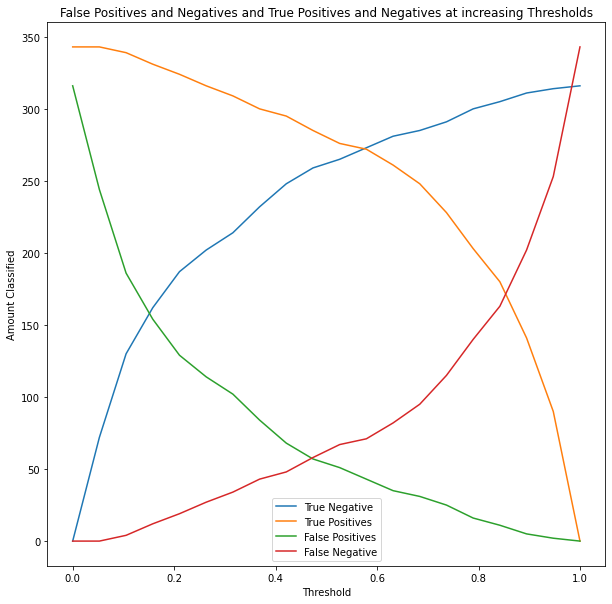

In [412]:
true_negative = []
true_positive = []
false_positive = []
false_negative = []
threshold = []

for i in np.linspace(0,1,20):
    
    pred = Y_pp.class_1_pp.apply(predict_at_threshold, args=[i])
    
    conf_matrix = confusion_matrix(y_test, pred, labels=[0,1])
    
    true_negative.append(conf_matrix[0,0])
    true_positive.append(conf_matrix[1,1])
    false_positive.append(conf_matrix[0,1])
    false_negative.append(conf_matrix[1,0])
    threshold.append(i)
    
    #print('Threshold for accepting result as belongning to high income: ', i, '\n' ,conf_matrix, '\n')
    
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(threshold, true_negative, label='True Negative')
ax.plot(threshold, true_positive, label='True Positives')
ax.plot(threshold, false_positive, label='False Positives')
ax.plot(threshold, false_negative, label='False Negative')

plt.title('False Positives and Negatives and True Positives and Negatives at increasing Thresholds')
plt.ylabel('Amount Classified')
plt.xlabel('Threshold')
plt.legend()

plt.show()

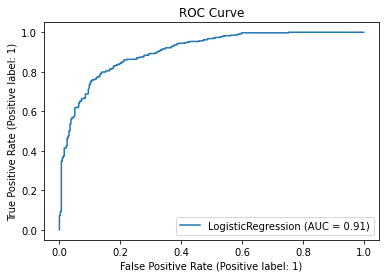

In [427]:
plot_roc_curve(log_model, df_test, y_test);
plt.title('ROC Curve')
plt.show()

The ROC curve measures plots the true positive rate (TPR) versus the false positive rate, as the threshold for predicting 1 changes.

- We measure the area under the curve. Whichs is 0.91
- If the TPR is always 1, the area under the curve is 1 (it cannot be larger). This is equivalent to perfect prediction.
- When the area under the curve is 0.50, this is equivalent to the baseline (chance) prediction (marked by the diagonal line).

-------

As explained above, we can tweak our model to decrease the amount of false positives and hence avoid telling our customers they will receive a high salary compared to low, the downsaide of this is that we reduce the entire models effectiveness as well as increase the false negative rates.

Recall or True positive Rate, is the amount of true positives divided by true positives plus false negatives. By changing the model as to the bosses predictions our recall rate would decrease, as the amount of false negatives increases.

On the other hand, we would see higher and higher levels of precision which is true positives divided by true positives + false positives. As the false positive number decreases with an increasing threshold.

------